<a href="https://colab.research.google.com/github/axefx/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Axel_Corro_LS_DS13_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [239]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
!pip install category_encoders==2.*
!pip install eli5

In [201]:

df = pd.read_csv('https://raw.githubusercontent.com/axefx/sample_datasets/master/investments_VC.csv', encoding= 'unicode_escape')
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
df.shape

(54294, 39)

In [0]:
# clean data - obj 5
def wrangle(df):
  df = df.copy()
  # Dropped nan if all columns in a row are empty.
  df = df.dropna(how='all')
  # format to dates
  df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce',infer_datetime_format=True)
  df['first_funding_at'] = pd.to_datetime(df['first_funding_at'],errors='coerce',infer_datetime_format=True)
  df['last_funding_at'] = pd.to_datetime(df['last_funding_at'],errors='coerce',infer_datetime_format=True)
  # clean spaces in columns
  df.columns = df.columns.str.strip()
  # drop rows with no status
  df = df[df['status'].notna()]
  return df

In [0]:
df = wrangle(df)

In [205]:
df.shape

(48124, 39)

In [0]:
# choose target - obj 1
target = 'status'

target is a classification problem

In [207]:
# type of problem - obj 2
df[target].value_counts(dropna=False)

operating    41829
acquired      3692
closed        2603
Name: status, dtype: int64

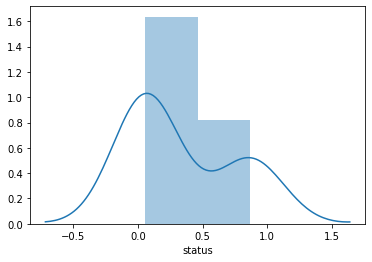

In [208]:
# target distribution - obj 3
import seaborn as sns
sns.distplot(df[target].value_counts(normalize=True));

In [0]:
# TODO baseline prediction with precision metric - obj 4

In [210]:
df.columns = df.columns.str.strip()
print(df.columns)
df.dtypes

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')


permalink                       object
name                            object
homepage_url                    object
category_list                   object
market                          object
funding_total_usd               object
status                          object
country_code                    object
state_code                      object
region                          object
city                            object
funding_rounds                 float64
founded_at              datetime64[ns]
founded_month                   object
founded_quarter                 object
founded_year                   float64
first_funding_at        datetime64[ns]
last_funding_at         datetime64[ns]
seed                           float64
venture                        float64
equity_crowdfunding            float64
undisclosed                    float64
convertible_note               float64
debt_financing                 float64
angel                          float64
grant                    

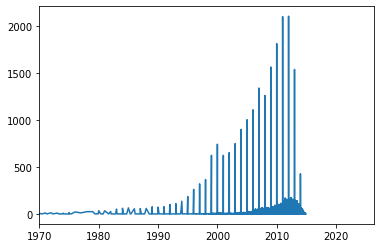

In [211]:
# explore with visuals - obj 3
fig, ax = plt.subplots()
ax.plot(df['founded_at'].value_counts().sort_index())
ax.set_xlim(np.datetime64('1970-01-01', 'Y'))
plt.show()

In [0]:
train, test = train_test_split(df, random_state=24)
train, val = train_test_split(train, random_state=24)

In [213]:
train.shape, val.shape, test.shape

((27069, 39), (9024, 39), (12031, 39))

In [214]:
# Choose which observations you will use to train, validate, and test your model.

# unusable columns
unusable = ['permalink','name','homepage_url']
train.drop(columns=unusable)

train_features = train.drop(columns=[target])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features
print(features)

['funding_rounds', 'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [217]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((27069, 23), (27069,), (9024, 23), (9024,))

In [233]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
)

# Fit on train
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.7457890070921985

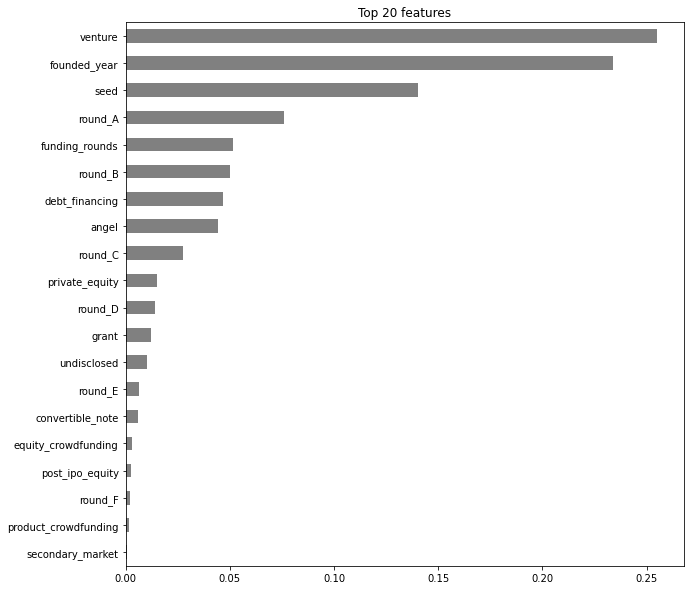

In [234]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [235]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median') 
)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [236]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_wei

In [237]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=features
)

Weight,Feature
0.0083 ± 0.0052,founded_year
0.0080 ± 0.0048,seed
0.0042 ± 0.0017,private_equity
0.0033 ± 0.0010,grant
0.0028 ± 0.0015,angel
0.0027 ± 0.0015,undisclosed
0.0020 ± 0.0007,post_ipo_equity
0.0016 ± 0.0026,debt_financing
0.0014 ± 0.0009,equity_crowdfunding
0.0007 ± 0.0004,product_crowdfunding


In [238]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier()
)

# Fit on train
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.8682402482269503